# Download GitHub repository and data
The repo wont be downloading in my local machine, since i already have it there. It will if someone is running this notebook on their own machine, colab, ...

In [ ]:
import os
import zipfile

images_path = 'ODIR-5K-multi-label-classification/data/images/'

# If the experiments folder doesnt exist im not in my local machine
if not os.path.exists('../../experiments'):
    # Clone project repository
    !git clone https://github.com/serdna1/ODIR-5K-multi-label-classification.git

    # Unzip images
    with zipfile.ZipFile(f'{images_path}/train_224.zip', 'r') as zip_ref:
      print("Unzipping training images...")
      zip_ref.extractall(f'{images_path}/train_224')
    !rm ODIR-5K-multi-label-classification/data/images/train_224.zip

    # Move to the experiment folder
    %cd ODIR-5K-multi-label-classification/experiments/experiment_0/

Cloning into 'ODIR-5K-multi-label-classification'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 216 (delta 103), reused 176 (delta 63), pack-reused 0
Receiving objects: 100% (216/216), 31.28 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Unzipping training images...
/content/ODIR-5K-multi-label-classification/experiments/experiment_0


# Drop some special patients from the dataset
The background of some images is quite different from the rest ones. Therefore they wont be used for training.

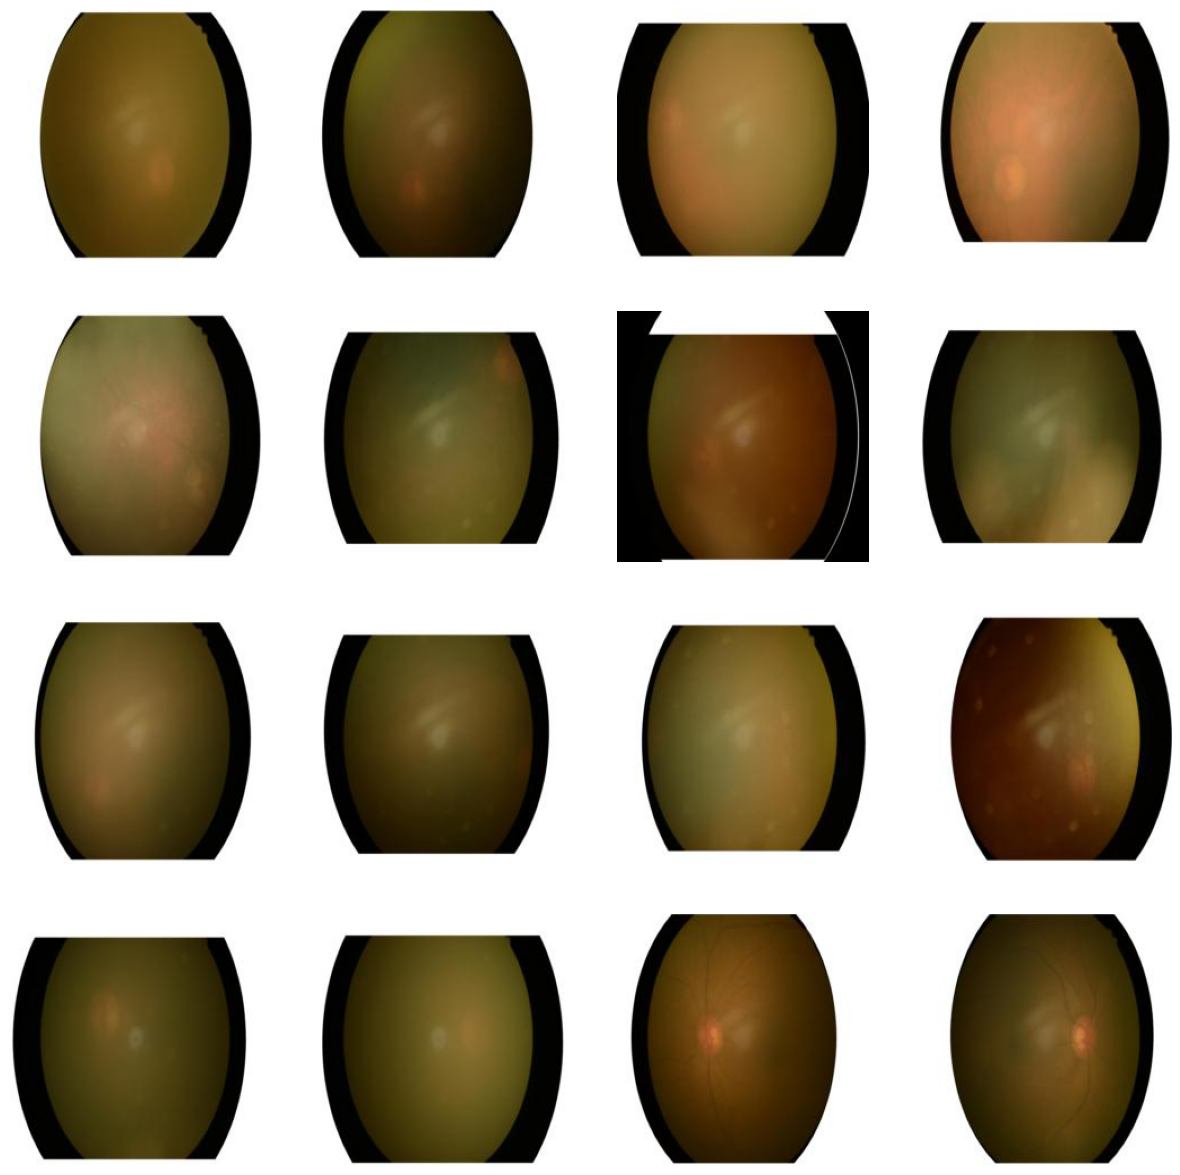

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

images_path = '../../data/images/train_224'

special_images = ['2174_right.jpg', '2175_left.jpg', '2176_left.jpg', '2177_left.jpg',
                  '2177_right.jpg', '2178_right.jpg', '2179_left.jpg', '2179_right.jpg',
                  '2180_left.jpg', '2180_right.jpg', '2181_left.jpg', '2181_right.jpg',
                  '2182_left.jpg', '2182_right.jpg', '2957_left.jpg', '2957_right.jpg']

image_path_list = [f'{images_path}/{image_name}' for image_name in special_images]
f, ax = plt.subplots(4, 4, figsize=(15,15))
for i, image_path in enumerate(image_path_list):
    img = Image.open(image_path)
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis(False)

In [ ]:
import pandas as pd

original_annotations_path = '../../data/annotations/annotations.xlsx'
annotations_path = 'data/annotations.xlsx'

odir_df = pd.read_excel(original_annotations_path)

patients_to_drop_df = odir_df[odir_df['Left-Fundus'].isin(special_images) | odir_df['Right-Fundus'].isin(special_images)]
patients_to_drop_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
1634,2174,65,Female,2174_left.jpg,2174_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0
1635,2175,63,Male,2175_left.jpg,2175_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1636,2176,82,Female,2176_left.jpg,2176_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
1637,2177,87,Male,2177_left.jpg,2177_right.jpg,normal fundus，lens dust,cataract,0,0,0,1,0,0,0,0
1638,2178,84,Male,2178_left.jpg,2178_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
1639,2179,70,Female,2179_left.jpg,2179_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
1640,2180,66,Female,2180_left.jpg,2180_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
1641,2181,79,Female,2181_left.jpg,2181_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
1642,2182,70,Male,2182_left.jpg,2182_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0
2334,2957,62,Female,2957_left.jpg,2957_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0


In [ ]:
from pathlib import Path

print(f'Annotations length before droping the rows with the special images: {len(odir_df)}')

odir_df = odir_df.drop(patients_to_drop_df.index) # Drop the special patients
Path('data/').mkdir(parents=True, exist_ok=True) # Create the experiment data folder
odir_df.to_excel(annotations_path) # Save annotations without the special patients

print(f'Annotations length after droping the rows with the special images: {len(odir_df)}')

Annotations length before droping the rows with the special images: 3500
Annotations length after droping the rows with the special images: 3490


# Check dataset label distribution

Text(0.5, 1.0, 'Label distribution')

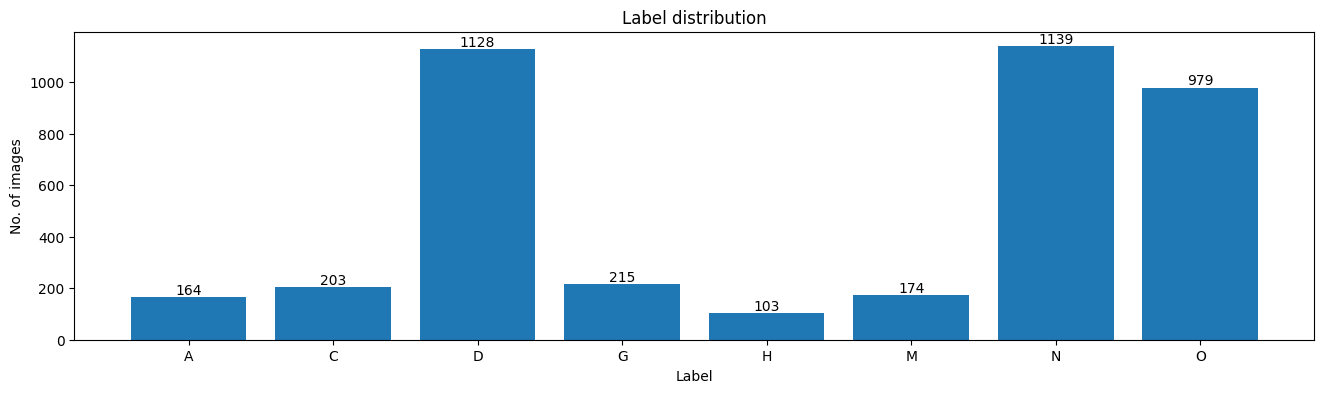

In [ ]:
label_names = ['A','C','D','G','H','M','N','O']

total_label_list = []
for label in label_names:
    total_label = int(odir_df.loc[:, [label]].sum())
    total_label_list.append(total_label)

plt.figure(figsize=(16,4))

bar = plt.bar(label_names, total_label_list)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.xlabel(f'Label')
plt.ylabel(f'No. of images')
plt.title(f'Label distribution')

# Split dataset into train and validation

In [ ]:
os.chdir('../../scripts/')
from utils import split_annotations
os.chdir('../experiments/experiment_0/')

In [ ]:
experiment_data_path = 'data/'

In [ ]:
# Split the original annotations file into train and validation annotations files
# val_ratio = 0.2 (value by default)
split_annotations(annotations_path, experiment_data_path, test_split=False)

# Read the previous three created .xlsx files into dataframes
train_df = pd.read_excel(f'{experiment_data_path}/train_annotations.xlsx')
val_df = pd.read_excel(f'{experiment_data_path}/val_annotations.xlsx')

len(train_df), len(val_df)

(2792, 698)

# Check train and validation datasets label distribution

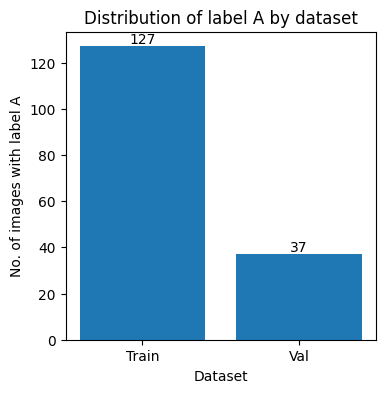

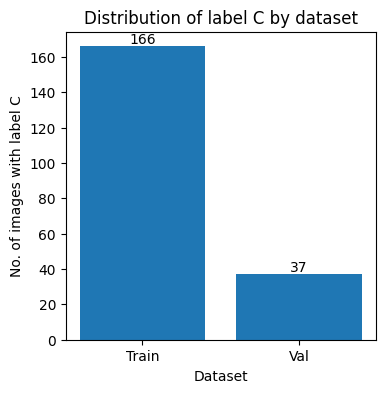

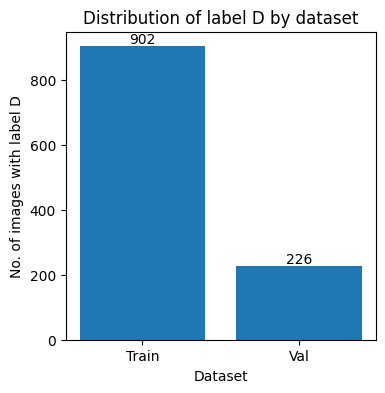

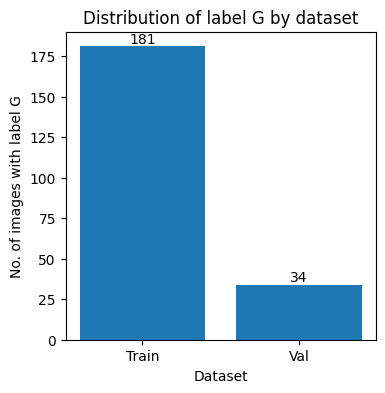

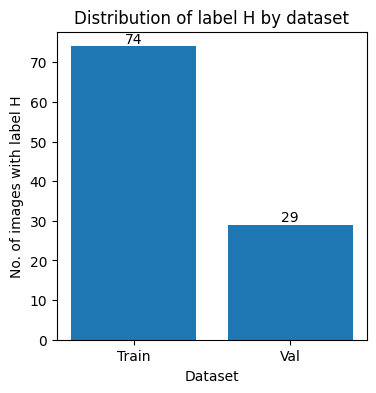

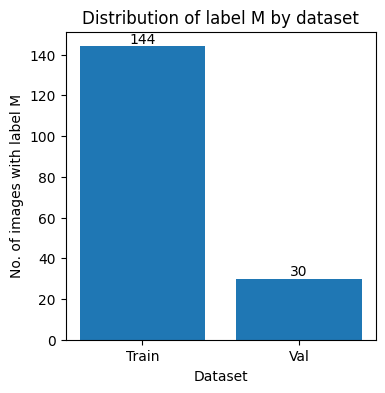

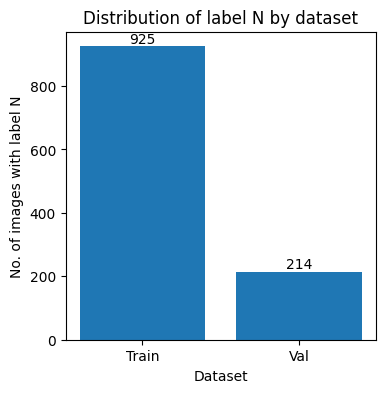

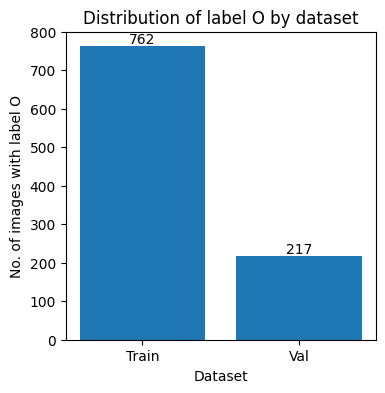

In [ ]:
for i, label in enumerate(label_names):
    plt.figure(figsize=(4,4))

    total_label_train = int(train_df.loc[:, [label]].sum())
    total_label_val = int(val_df.loc[:, [label]].sum())

    bar = plt.bar(['Train', 'Val'], [total_label_train, total_label_val])

    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.xlabel(f'Dataset')
    plt.ylabel(f'No. of images with label {label}')
    plt.title(f'Distribution of label {label} by dataset')

# Train the model

In [ ]:
%run ../../scripts/train.py -h # Run this line to check the train script arguments

usage: train.py [-h] [--random_seed RANDOM_SEED] [--images_path IMAGES_PATH]
                [--use_normalization]
                [--train_annotations_path TRAIN_ANNOTATIONS_PATH]
                [--val_annotations_path VAL_ANNOTATIONS_PATH]
                [--batch_size BATCH_SIZE] [--num_workers NUM_WORKERS]
                [--lr LR] [--momentum MOMENTUM] [--epochs EPOCHS]
                [--patience PATIENCE] [--experiment_name EXPERIMENT_NAME]
                [--extra EXTRA]

Train a network for image multi-label classification on ODIR-5K.

options:
  -h, --help            show this help message and exit
  --random_seed RANDOM_SEED
                        Sets random seed for reproducibility (default: 42).
  --images_path IMAGES_PATH
                        Path of ODIR training images (default:
                        /kaggle/input/odir-size-512/odir-size-512).
  --use_normalization   If set the images are normalized the same way the
                        imagenet images where 

<Figure size 640x480 with 0 Axes>

In [ ]:
images_path = '../../data/images/train_224'
train_annotations_path = 'data/train_annotations.xlsx'
val_annotations_path = 'data/val_annotations.xlsx'
batch_size = 32
epochs = 50
patience = 5
experiment_name = 'experiment_0'

In [ ]:
%run ../../scripts/train.py --images_path {images_path} --train_annotations_path {train_annotations_path} --val_annotations_path {val_annotations_path}\
                            --batch_size {batch_size} --epochs {epochs} --patience {patience} --experiment_name {experiment_name} --use_normalization

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.9MB/s]


[INFO] Created new resnet50_dual model.
[INFO] Created SummaryWriter, saving to: ../runs/resnet50_dual/experiment_0...


  0%|          | 0/50 [00:00<?, ?it/s]

Ep: 0 | t_loss: 0.5048 | t_kappa: -0.0024 | t_f1: 0.0795 | t_auc: 0.5093 | t_final: 0.1955 | v_loss: 0.4123 | v_kappa: 0.0000 | v_f1: 0.0000 | v_auc: 0.5286 | v_final: 0.1762
Validation loss decreased (inf --> 0.412303).  Saving model ...
Ep: 1 | t_loss: 0.3795 | t_kappa: 0.0000 | t_f1: 0.0000 | t_auc: 0.5448 | t_final: 0.1816 | v_loss: 0.3800 | v_kappa: 0.0000 | v_f1: 0.0000 | v_auc: 0.5489 | v_final: 0.1830
Validation loss decreased (0.412303 --> 0.379982).  Saving model ...
Ep: 2 | t_loss: 0.3608 | t_kappa: 0.0000 | t_f1: 0.0000 | t_auc: 0.5658 | t_final: 0.1886 | v_loss: 0.3697 | v_kappa: 0.0000 | v_f1: 0.0000 | v_auc: 0.5637 | v_final: 0.1879
Validation loss decreased (0.379982 --> 0.369685).  Saving model ...
Ep: 3 | t_loss: 0.3533 | t_kappa: 0.0000 | t_f1: 0.0000 | t_auc: 0.5848 | t_final: 0.1949 | v_loss: 0.3618 | v_kappa: 0.0000 | v_f1: 0.0000 | v_auc: 0.5723 | v_final: 0.1908
Validation loss decreased (0.369685 --> 0.361803).  Saving model ...
Ep: 4 | t_loss: 0.3502 | t_kappa

Run the next cell to see the metrics trough the epochs using the tensorboard interface

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ../runs

# Test on validation dataset
Since there is no access to the test annotatations (only to the images) the test will be performed on the validation dataset, to be able to see some results.

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

os.chdir('../../scripts')
from datasets import ODIRDataset
from utils import load_model
from metrics import compute_challenge_metrics, plot_confusion_matrices
os.chdir('../experiments/experiment_0/')

In [ ]:
val_annotations_path = 'data/val_annotations.xlsx'
images_path = '../../data/images/train_224'
model_path = 'outputs/resnet50_dual_experiment_0_model.pth'
ground_truth_path = 'outputs/ground_truth.xlsx'
probs_path = 'outputs/probs.xlsx'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = load_model(model_path)
model.to(device)
model.name

[INFO] Created new resnet50_dual model.


'resnet50_dual'

In [ ]:
# Create test transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create test dataset
val_df = pd.read_excel(val_annotations_path)

val_dataset = ODIRDataset(images_path, val_df, transform)

# Create the ground truth df that will be used as one of the arguments
# when run the challenge evaluation file (ODIR_evaluation.py)
gt_df = val_df.loc[:, ['ID','N','D','G','C','A','H','M','O']]
gt_df = gt_df.reset_index(drop=True)
gt_df.to_excel(ground_truth_path, index=False)

# Create test dataloader
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            pin_memory=True,
                            shuffle=False)

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
model.eval()

test_loss = 0
all_y = torch.tensor([], dtype=torch.float32).to(device)
all_probs = torch.tensor([], dtype=torch.float32).to(device)

with torch.inference_mode():
    for ((X_left, X_right), y) in val_dataloader:
        X_left, X_right, y = X_left.to(device), X_right.to(device), y.to(device)

        logits = model(X_left, X_right)
        probs = torch.sigmoid(logits)

        loss = loss_fn(logits, y)
        test_loss += loss.item()

        all_y = torch.cat((all_y, y))
        all_probs = torch.cat((all_probs, probs))

all_y = all_y.detach().cpu().numpy()
all_probs = all_probs.detach().cpu().numpy()

# Create a df to store the probabilities of each patient in the val dataset
probs_df = pd.DataFrame(all_probs, columns=['A','C','D','G','H','M','N','O'])
probs_df.insert(0, 'ID', val_df['ID'])
probs_df = probs_df.loc[:, ['ID','N','D','G','C','A','H','M','O']]
probs_df.to_excel(probs_path, index=False)

test_loss = test_loss / len(val_dataloader)
kappa, f1, auc, final_score = compute_challenge_metrics(all_y, all_probs)

# Cuantitative results
The next metrics will be shown for test: loss, kappa, f1, AUC, final score (the mean of the previous three), the sklearn classification report and one confusion matrix for each label,

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit([['A','C','D','G','H','M','N','O']])
label_names = mlb.classes_

test_loss: 0.3353 | test_kappa: 0.0167 | test_f1: 0.0855 | test_auc: 0.6300 | test_final: 0.2441

Clasification report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        37
           C       0.00      0.00      0.00        37
           D       0.46      0.11      0.17       226
           G       0.00      0.00      0.00        34
           H       0.00      0.00      0.00        29
           M       0.00      0.00      0.00        30
           N       0.58      0.08      0.15       214
           O       0.00      0.00      0.00       217

   micro avg       0.51      0.05      0.09       824
   macro avg       0.13      0.02      0.04       824
weighted avg       0.28      0.05      0.09       824
 samples avg       0.06      0.06      0.06       824




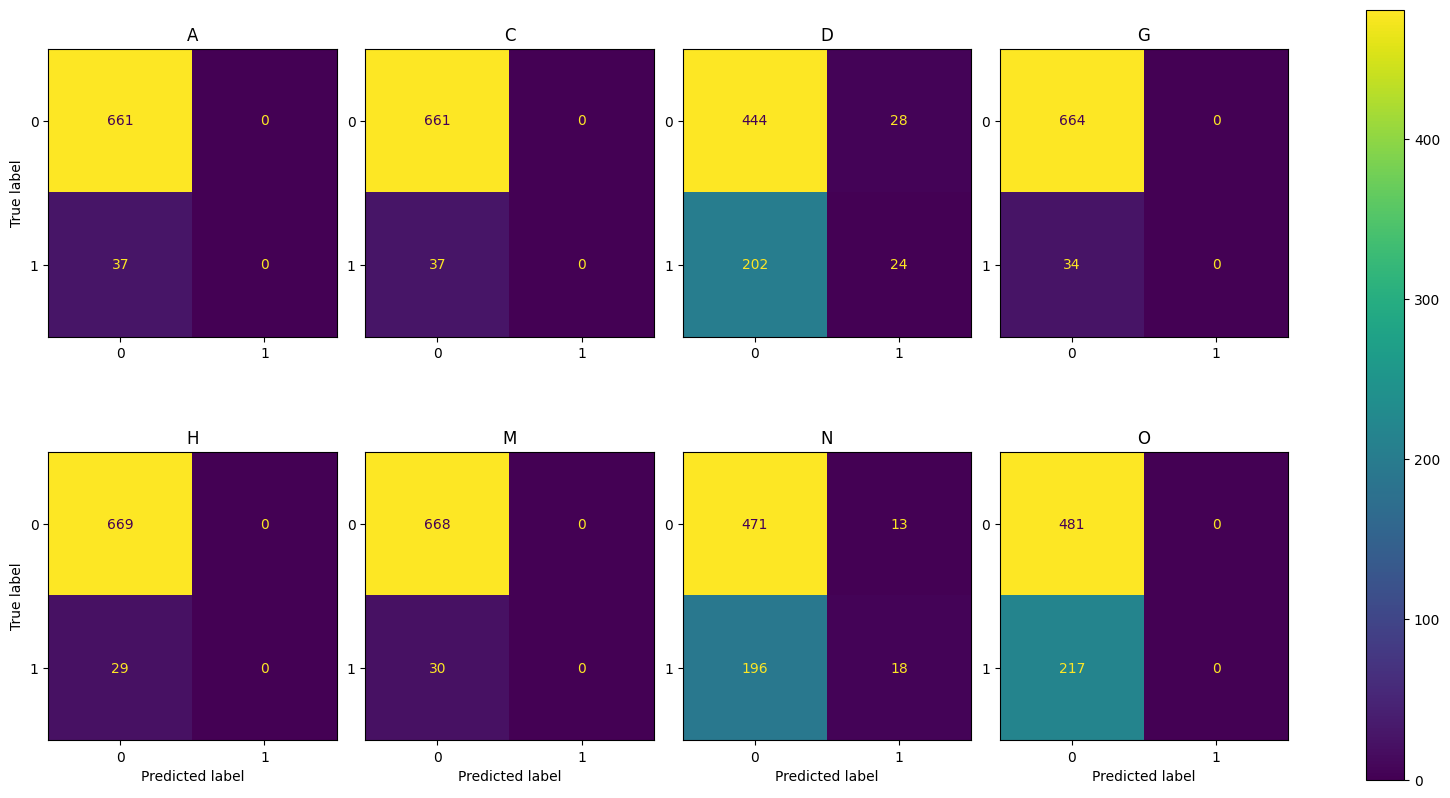

In [ ]:
print(
    f"test_loss: {test_loss:.4f} | "
    f"test_kappa: {kappa:.4f} | "
    f"test_f1: {f1:.4f} | "
    f"test_auc: {auc:.4f} | "
    f"test_final: {final_score:.4f}\n"
)

# Print test classification report
print('Clasification report:')
print(
    metrics.classification_report(
        all_y,
        all_probs>0.5,
        output_dict=False,
        target_names=label_names,
        zero_division=0
    )
)
print()

# Plot one confusion matrix for each label
plot_confusion_matrices(all_y, all_probs, label_names)

# Cualitative results
Two patients with each disease (at least) are predicted (16 predictions). The original images are ploted along with their original and predicted labels.

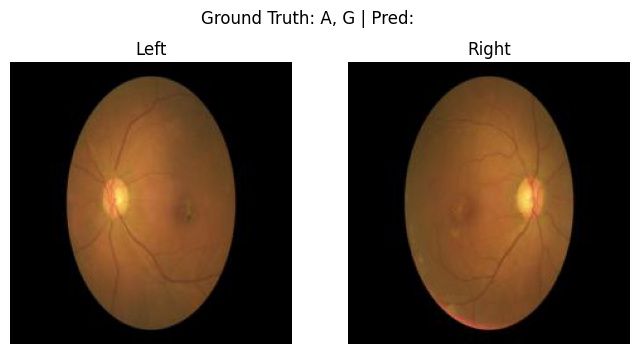

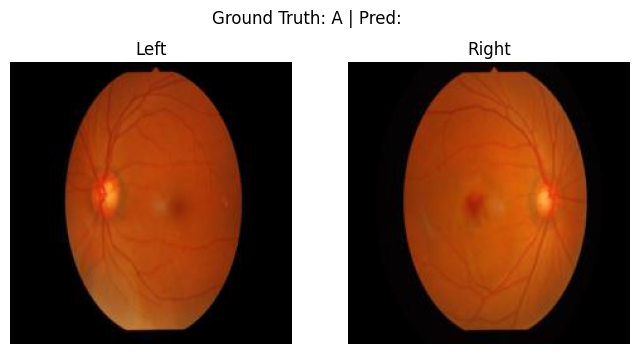

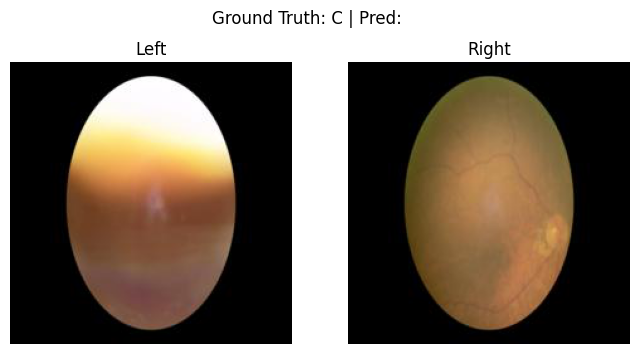

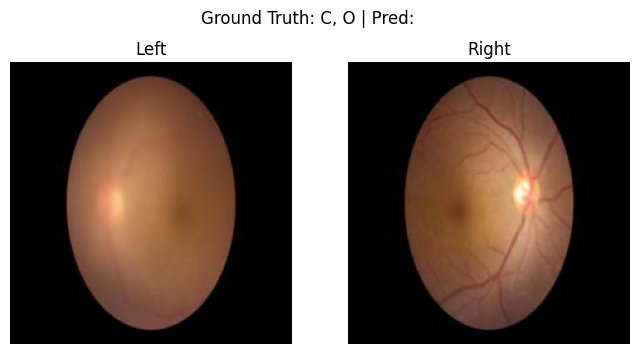

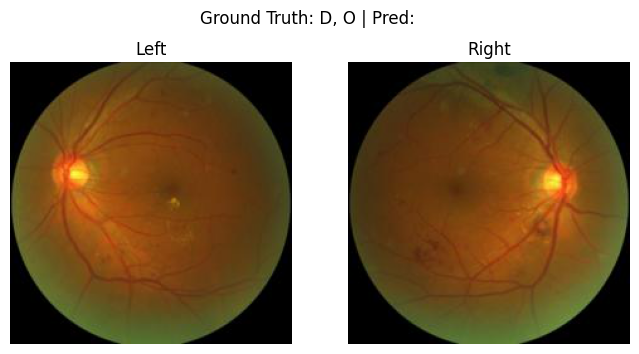

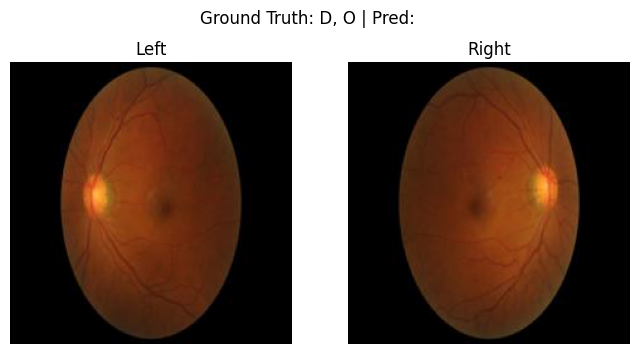

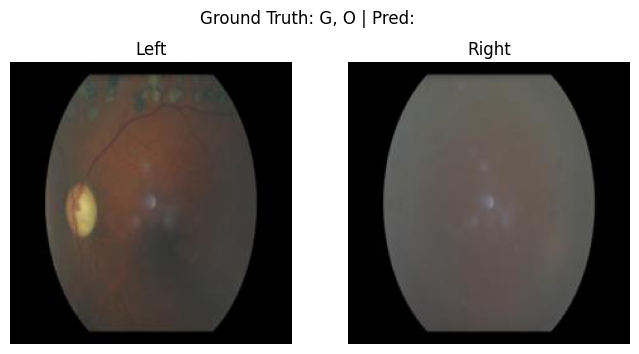

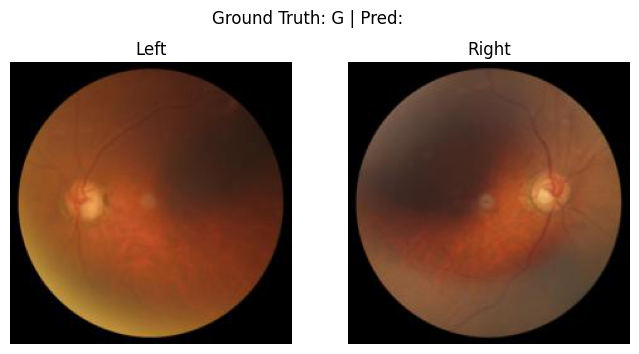

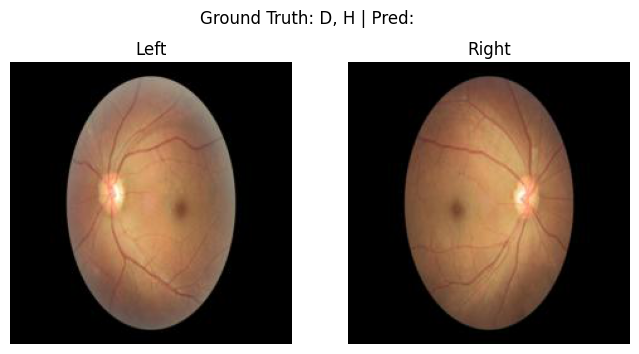

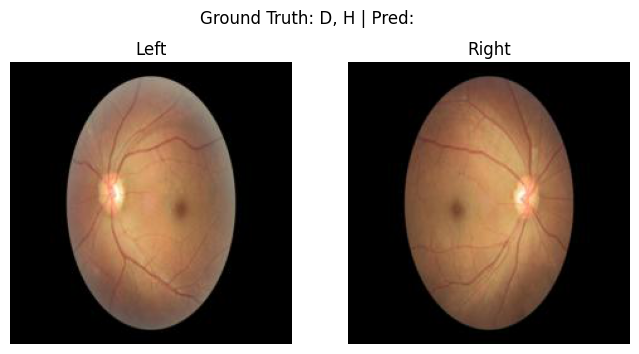

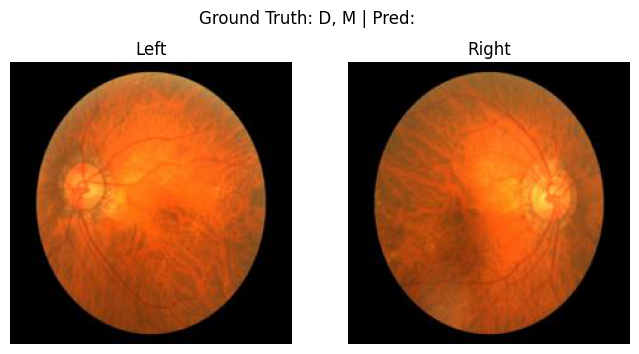

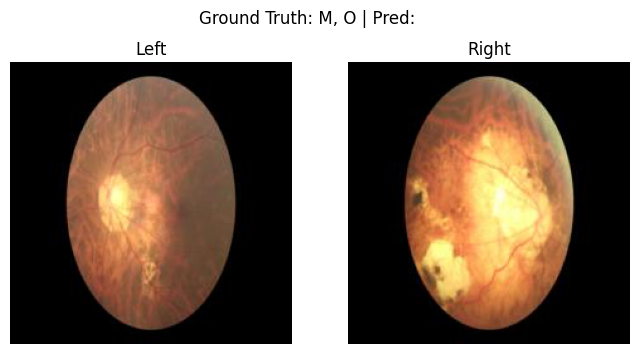

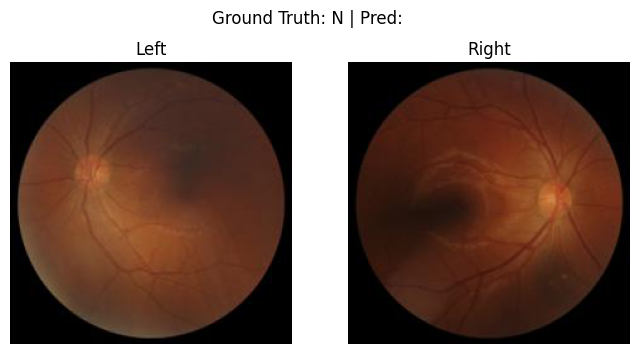

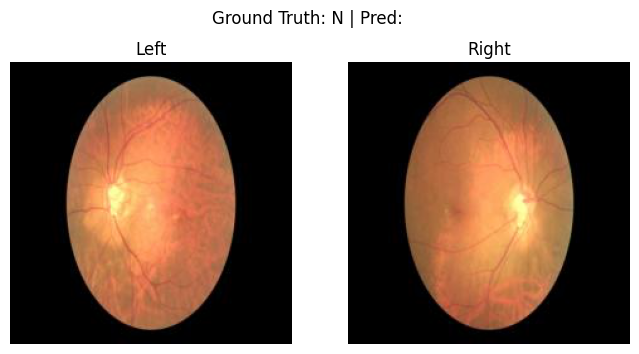

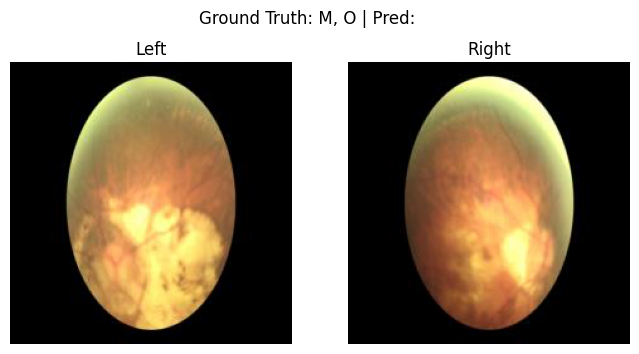

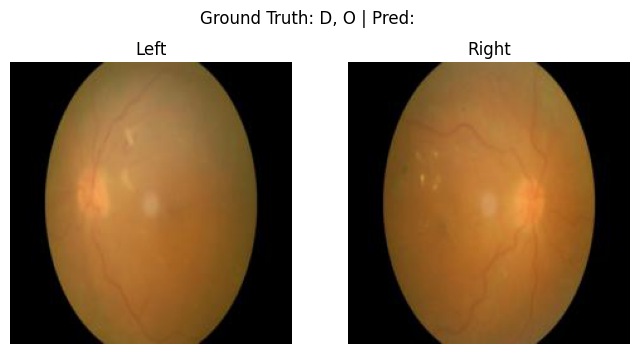

In [ ]:
for label in label_names:
    label_df = val_df[val_df[label] == 1].sample(2, replace=True).reset_index(drop=True)
    for i in range(2):
        plt.figure(figsize=(8,4))

        left_image_path = f'{images_path}/{label_df.at[i, "Left-Fundus"]}'
        left_img = Image.open(left_image_path)
        plt.subplot(1,2,1)
        plt.imshow(left_img)
        plt.title('Left')
        plt.axis(False)

        right_image_path = f'{images_path}/{label_df.at[i, "Right-Fundus"]}'
        right_img = Image.open(right_image_path)
        plt.subplot(1,2,2)
        plt.imshow(right_img)
        plt.title('Right')
        plt.axis(False)

        gt_labels = label_df.loc[i, ['A','C','D','G','H','M','N','O']].to_numpy()
        gt_labels = mlb.inverse_transform(np.expand_dims(gt_labels, axis=0))

        left_img = transform(left_img).unsqueeze(dim=0).to(device)
        right_img = transform(right_img).unsqueeze(dim=0).to(device)
        pred_labels = torch.sigmoid(model(left_img, right_img))>0.5
        pred_labels = mlb.inverse_transform(pred_labels.cpu().numpy())


        gt_labels = ', '.join(np.squeeze(gt_labels, axis=0))
        pred_labels = ', '.join(np.squeeze(pred_labels, axis=0))
        plt.suptitle(f'Ground Truth: {gt_labels} | Pred: {pred_labels}')

# Zip the experiment data folder, the SummaryWriter folder and the experiment outputs
This is necessary in order to be able to download this folders

In [ ]:
import shutil

shutil.make_archive('experiment_data_compressed',
                    format="zip",
                    root_dir='data/')

shutil.make_archive('runs_compressed',
                    format="zip",
                    root_dir='../runs/')

shutil.make_archive('outputs_compressed',
                    format="zip",
                    root_dir='outputs/')

'/content/ODIR-5K-multi-label-classification/experiments/experiment_0/outputs_compressed.zip'